## Recursion formulae for $\mathcal{J}_v$

In this notebook we validate our recursion formulae for the integral $\mathcal{J}$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [6]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpmath import ellipf, ellipe
from tqdm.notebook import tqdm
from scipy.special import binom
import warnings

warnings.simplefilter("ignore")

Here is the definition of the $\mathcal{J}$ integral, which we compute numerically:

In [ ]:
def Jexact(v, k, kappa):
    """
    The function J_v evaluated by direct numerical integration.
    
    """
    res = 0
    for i in range(0, len(kappa), 2):
        func = (
            lambda x: np.sin(x) ** (2 * v)
            * (1 - k ** (-2) * np.sin(x + 0j) ** 2) ** 1.5
        )
        res += quad(
            func, 0.5 * kappa[i], 0.5 * kappa[i + 1], epsabs=1e-12, epsrel=1e-12,
        )[0]
    return res

And here is our analytic expression, computed from two lower bounds and a three-term upward recurrence relation:

In [ ]:
@np.vectorize
def E(phi, k2):
    """Incomplete elliptic integral of the first kind."""
    return float(ellipe(phi, k2).real)

@np.vectorize
def F(phi, k2):
    """Incomplete elliptic integral of the second kind."""
    return float(ellipf(phi, k2).real)


def Delta(x):
    """The sum over the pairwise differences of an array."""
    return sum(-np.array(x)[::2] + np.array(x)[1::2])


def J(v, k, kappa):
    """
    The function J_v computed from two lower boundary conditions
    and a three-term upward recurrence relation.
    
    """
    k2 = k ** 2
    km2 = k ** -2
    q = np.sqrt(np.maximum(0, 1 - km2 * np.sin(0.5 * kappa) ** 2))
    z0 = np.sin(0.5 * kappa) * np.cos(0.5 * kappa) * q * km2
    z1 = ((3 * np.sin(0.5 * kappa) ** 2 + 4) - 6 * k2) * z0
    zv = q ** 5 * np.sin(0.5 * kappa) ** (2 * v - 3) * np.cos(0.5 * kappa) * k2

    if v == 0:

        return (1 / 3) * (
            2 * (2 - km2) * Delta(E(kappa / 2, km2))
            + (km2 - 1) * Delta(F(kappa / 2, km2))
            + Delta(z0)
        )

    elif v == 1:

        return (1 / 15) * (
            (-3 * k2 + 13 - 8 * km2) * Delta(E(kappa / 2, km2))
            + (3 * k2 - 7 + 4 * km2) * Delta(F(kappa / 2, km2))
            + Delta(z1)
        )

    else:

        return (
            2 * (v + (v - 1) * k2 + 1) * J(v - 1, k, kappa)
            - (2 * v - 3) * k2 * J(v - 2, k, kappa)
            + Delta(zv)
        ) / (2 * v + 3)

We can verify that the two expressions agree for all $\{\kappa_1, \kappa_2 \}$ and for any $N$ (we choose 3 here for definiteness):

Text(0, 0.5, 'J_3')

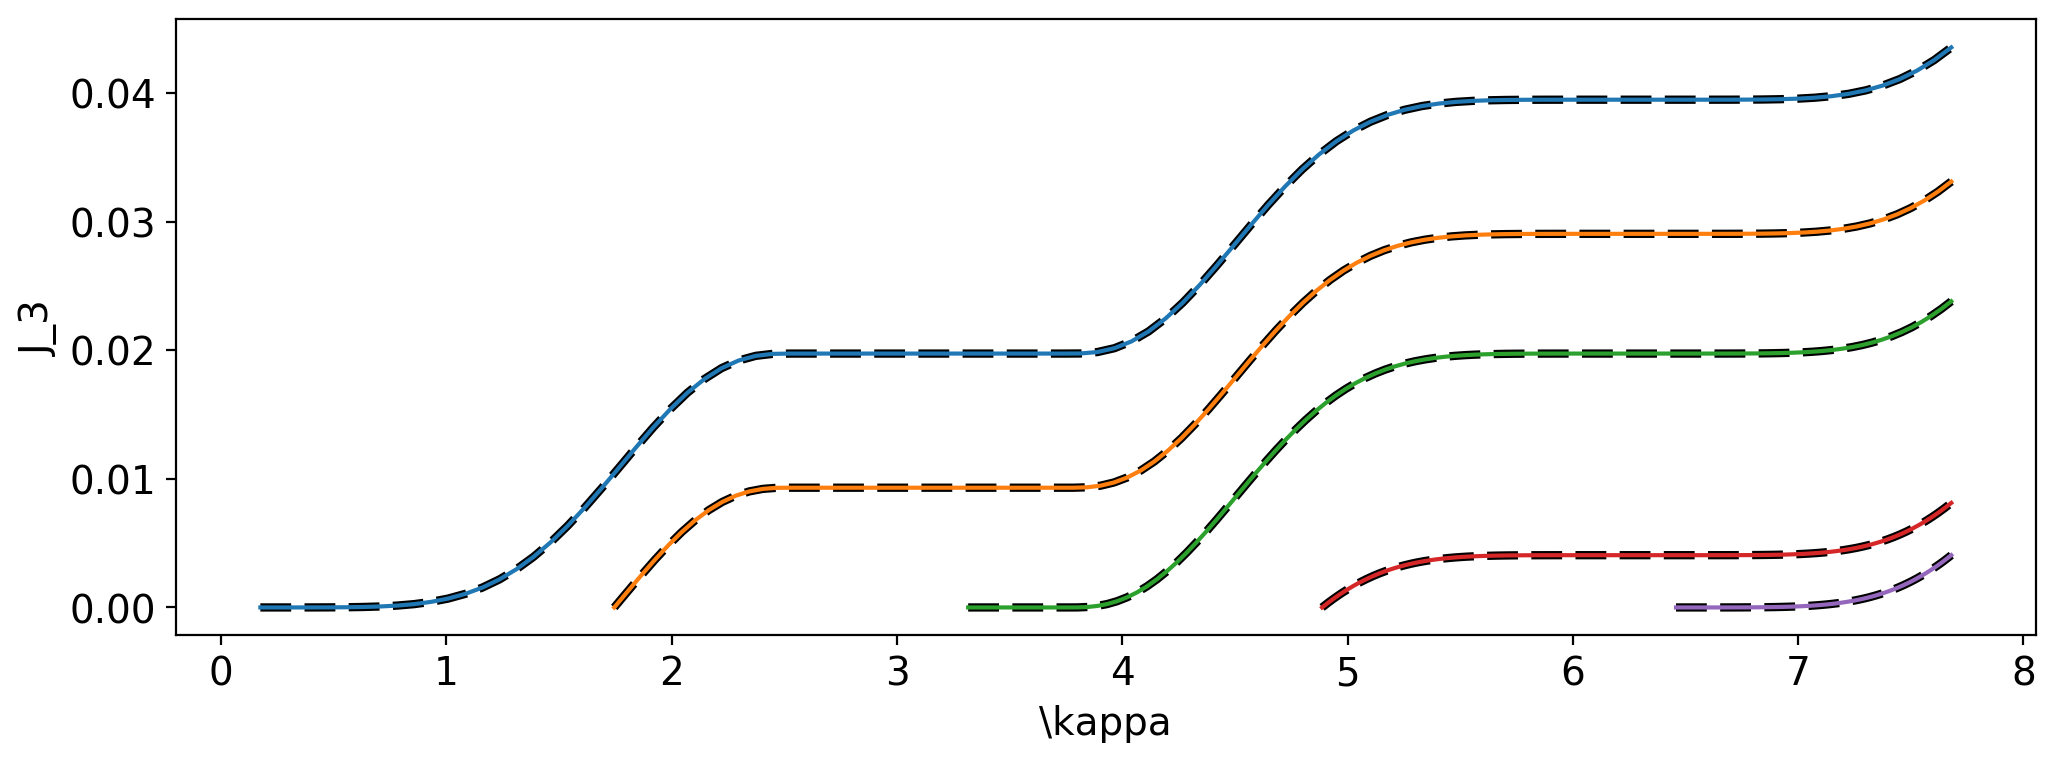

In [58]:
# Validation
k = 0.95
for kappa1 in np.array([10, 100, 190, 280, 370]) * np.pi / 180:
    arr = np.linspace(kappa1, 440 * np.pi / 180, 100)
    plt.plot(arr, [Jexact(3, k, np.array([kappa1, kappa2])) for kappa2 in arr], "k--", lw=3)
    plt.plot(arr, [J(3, k, np.array([kappa1, kappa2])) for kappa2 in arr])
plt.xlabel("\kappa")
plt.ylabel("J_3")

## Tridiagonal solve for J

The upward recurrence relation presented above has poor stability in general. We can attain much higher stability by instead solving a tridiagonal system with a lower and an upper boundary condition.

In [49]:
def solve_numerical(N, k, kappa):
    """Numerical solution for all J_v, 0 <= v <= N."""
    return np.array([Jexact(v, k, kappa) for v in range(N + 1)])


def solve(N, k, kappa):
    """
    Return the array J[0 .. N], computed recursively using
    a tridiagonal solver and a lower boundary condition
    (analytic in terms of elliptic integrals) and an upper
    boundary condition (computed as a series solution).
    
    """
    # Useful quantities
    k2 = k ** 2
    km2 = k ** -2
    sin = np.sin(0.5 * kappa)
    cos = np.cos(0.5 * kappa)
    q = np.sqrt(np.maximum(0, 1 - km2 * sin ** 2))

    # Boundary conditions
    J0 = Jexact(0, k, kappa)
    JN = Jexact(N, k, kappa)

    # Set up the tridiagonal problem
    a = np.empty(N - 1)
    b = np.empty(N - 1)
    c = np.empty(N - 1)
    for i, v in enumerate(range(2, N + 1)):
        a[i] = -2 * (v + 1 + (v - 1) * k2) / (2 * v + 3)
        b[i] = (2 * v - 3) * k2 / (2 * v + 3)
        c[i] = Delta(k2 * sin ** (2 * v - 3) * cos * q ** 5) / (2 * v + 3)

    # Add the boundary conditions
    c[0] -= b[0] * J0
    c[-1] -= JN

    # Construct the tridiagonal matrix
    A = np.diag(a, 0) + np.diag(b[1:], -1) + np.diag(np.ones(N - 2), 1)

    # Solve
    soln = np.linalg.solve(A, c)
    return np.concatenate(([J0], soln, [JN]))

Here's a simply check that the tridiagonal solver agrees with direct numerical integration for a specific combination of input parameters:

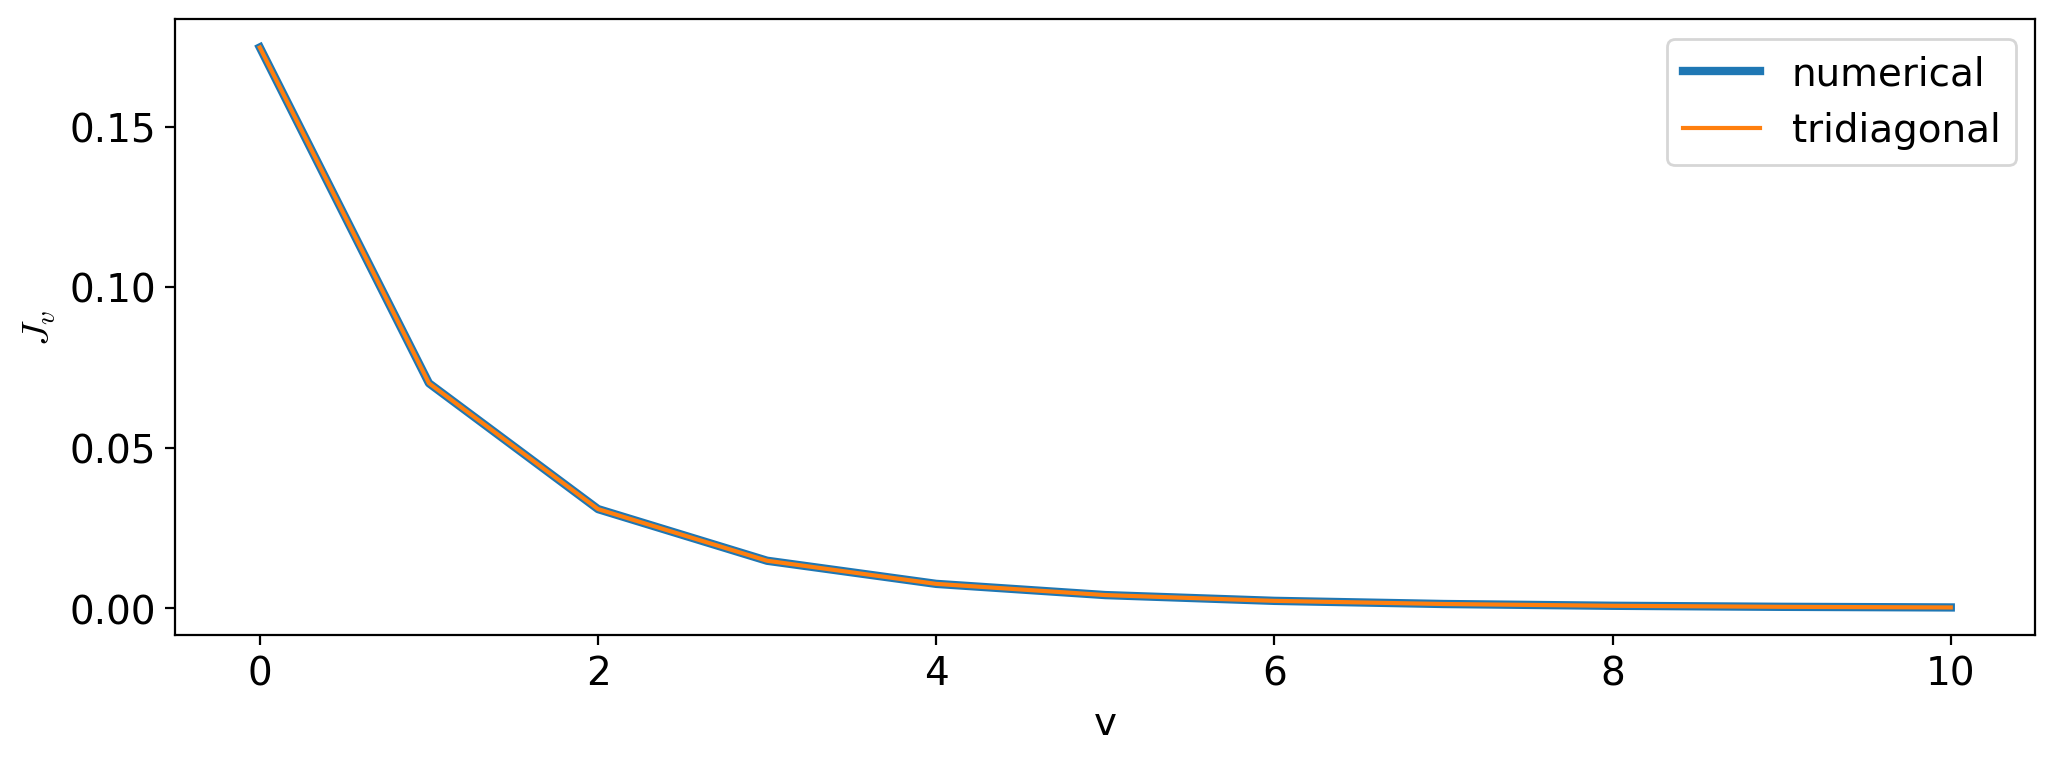

In [60]:
k = 0.95
kappa = np.array([1.0, 2.0])
N = 10
plt.plot(solve_numerical(N, k, kappa), lw=3, label="numerical")
plt.plot(solve(N, k, kappa), lw=1.5, label="tridiagonal")
plt.xlabel("v")
plt.ylabel("$J_v$")
plt.legend();

## Solver stability

Let's randomize values of $k$ and $\kappa$ and compute the log of the difference between the tridiagonal solution and the numerical solution:

In [61]:
def random_k():
    """Random k in the range [0, 1] or [1, 20]."""
    if np.random.random() < 0.5:
        return np.random.random()
    else:
        return 1 + 19 * np.random.random()


def random_kappa():
    """Random (kappa1, kappa2) in the range [0, 2pi] with kappa2 > kappa1."""
    kappa1 = 2 * np.pi * np.random.random()
    kappa2 = kappa1 + (2 * np.pi - kappa1) * np.random.random()
    return np.array([kappa1, kappa2])


ntimes = 1000
N = 20
logdiff = np.zeros((ntimes, N + 1))
for i in tqdm(range(ntimes)):
    k = random_k()
    kappa = random_kappa()
    logdiff[i] = np.log10(
        np.maximum(1e-16, np.abs(solve(N, k, kappa) - solve_numerical(N, k, kappa)))
    )

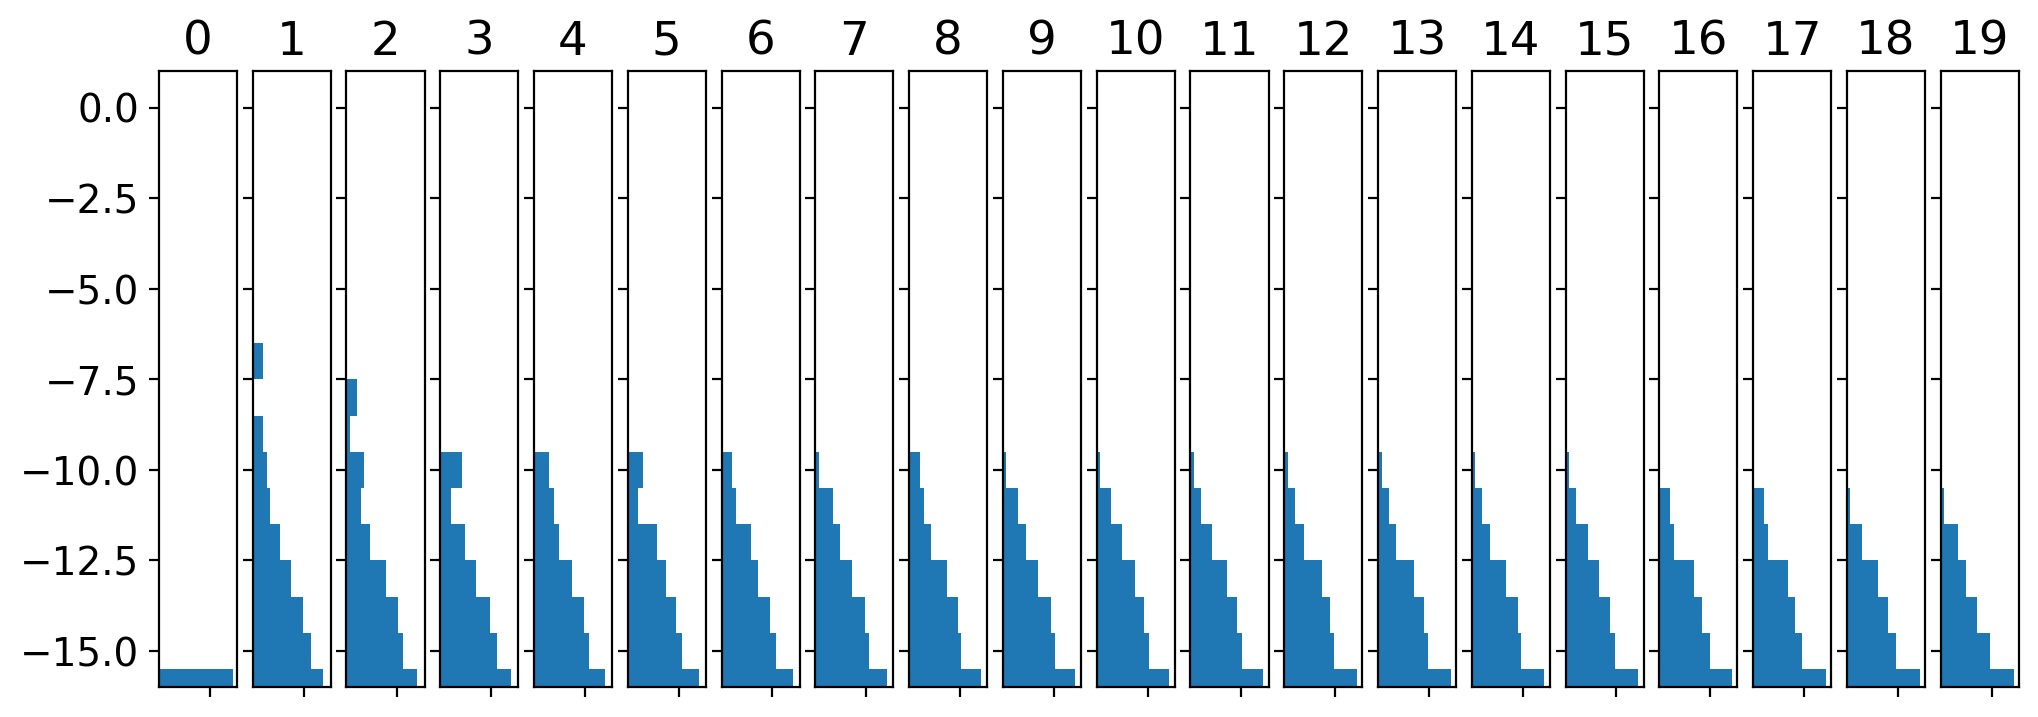

In [55]:
fig, ax = plt.subplots(1, N, sharex=True, sharey=True)
ax[0].set_ylim(-16, 1)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
for i, axis in enumerate(ax):
    axis.set_title(i)
    axis.hist(logdiff[:, i], orientation="horizontal", bins=np.arange(-16.5, 0))

The expressions agree to within better than $10^{-10}$ in almost all cases.